In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Introduction

There's a common notion that people's decisions are "noisy". But if the point of value-learning is to come up with really good estimates of the stimuli in an environment, why should we ever choose something that we expect will produce less reward? It seems that there's a need to translate value-learning into decision-making, and a good model needs to account for why a translation is necessary.

Based on [Hanneke den Ouden's](http://hannekedenouden.ruhosting.nl/RLtutorial/Instructions.html) tutorial on reinforcement learning.

## 1.1 The explore/exploit tradeoff

Let's say we're trying to pick between two slot machines that we suspect have different payouts. We have two problems here. First, we need to learn a decent value estimate for each of those slot machines. We've already thought about this in the case of a single slot machine. Second, we need to translate that value estimate into a decision. In other words, we need a **`choice rule`**. The simplest choice rule is simply to pick the slot machine that has the highest value, no matter what. But this seems like a choice rule that could have some problems. Are we convinced that it's wise to commit to a single slot machine for time eternal after, say, 20 trials of experience on both slot machines? Let's imagine for a second, also, that we believe the probability of winning on a given slot machine changes over time (it doesn't have to be true, we just have to believe it). Then it *really* doesn't make sense for us to stick with a single slot machine forever and ever.

This is an informal way of understanding the **`explore/exploit tradeoff`**, which helps explain why our decision-making can sometimes appear to be "noisy." A little bit of exploration might cause us to choose something suboptimal in the short-run, but can also lead us to obtain better value estimates in the long-run.

We can model this using a **`softmax`** choice rule:

$ p(\text{choose higher-value stimulus } s) = \cfrac{\text{exp}(\beta \times V_{s})}{\sum_{i} \text{exp}(\beta \times V_{i})} $

which says that the probability of choosing the higher-value stimulus *s* increases as its value increases. But, it also leaves open the possibility for some randomness (exploration) depending on the value of $\beta$:  
smaller $\rightarrow$ more random  
larger $\rightarrow$ more deterministic acccording to the value difference

Importantly, the choice rule operates independently from the value-learning function. You could have any value-learning function you wanted (for the sake of illustration, we could have one that assigns rewards from the blue slot machine to have 10x more value than monetarily-equivalent rewards from the orange slot machine). But until you put those values into a choice rule, there's no telling how the value will translate into a decision.

## 1.2 Simulating multiple slot machines

We've got two slot machines, one blue and one orange. Unbeknownst to us, they have different probabilities of producing reward.

In [2]:
def play_slot_machine(p_winning, n_plays = 1):
    return np.random.binomial(n = 1, p = p_winning, size = n_plays)

## 1.3 Value learning

We'll use the Rescorla-Wagner learning model from last time, though we'll generalize the function so that it can handle any arbitrary number of stimuli.

In [3]:
def learn_rescorla_wagner(alpha, this_reward, which_stims, prev_values):
    """
    For a single learning event, updates stimulus values in a Rescorla-Wagner agent.

        Arguments:
            alpha:          scalar with range [0, 1]
            this_reward:    scalar of arbitrary magnitude
            which_stims:    1-D numpy array where each element represents whether a stimulus is present (1=Yes, 0=No)
            prev_values:    1-D numpy array where each element represents the previously-learned value of all stimuli

        Returns:
            updated_values: 1-D numpy array where each element represents the updated value of all stimuli
    """
    
    delta = this_reward - np.sum(which_stims * prev_values)
    updated_values = prev_values + (alpha * delta * which_stims)

    return updated_values

## 1.4 Softmax choice rule

Now we'll implement the softmax. It is in a generalized form so that it can make predictions about an arbitrary number of stimuli.

In [4]:
def choose_softmax(beta, stim_values):
    """
    Given current stimulus value estimates, compute the probability of choosing a particular stimulus. "Choose" one stimulus.

    Arguments:
            beta:           scalar with range [0, Inf]
            stim_values:    1-D numpy array where each element represents the learned value of all stimuli
    
    Returns:
            choice:             scalar indicating the index of the chosen option
            choice_probs:       1-D numpy array where each element represents the probability of choosing a stimulus
    """

    softmax_numerators = np.exp(beta * stim_values)
    softmax_denominator = np.sum(softmax_numerators)
    choice_probs = softmax_numerators / softmax_denominator

    choice = np.random.multinomial(n = 1, pvals = choice_probs)

    return choice, choice_probs

Just to see how it works with different values of $\beta$, let's plot the probability of choosing stimulus A (vs stimulus B).

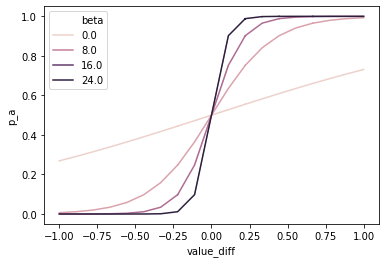

In [5]:
sim_softmax = np.array(
    [(x, y, z) for x in np.linspace(-0.5, 0.5, 10) for y in np.linspace(-0.5, 0.5, 10) for z in (1, 5, 10, 20)]
    )

p_choice = np.empty((len(sim_softmax), 2))

for x in np.arange(len(sim_softmax)):
    _, p_choice[x, :] = choose_softmax(beta = sim_softmax[x, 2], stim_values = sim_softmax[x, 0:2])

sim_softmax = pd.DataFrame(
    np.append(sim_softmax, p_choice, axis = 1),
    columns = ['value_a', 'value_b', 'beta', 'p_a', 'p_b']
    )

sim_softmax = sim_softmax.assign(value_diff = lambda x: (x['value_a'] - x['value_b']))

sns.lineplot(
    x='value_diff',
    y='p_a',
    hue='beta',
    data=sim_softmax
)

# 2.0 Simulate decision-making

## 2.1 Simulate experiment

Now that we have all of the requisite components, we can simulate how a particular agent would learn (and then make decisions about) the two slot machines. This setup is known in the RL literature as a **`two-armed bandit`** task, so named because it's a two-option extension of the one-armed bandit.

The function itself is generalized so that we could (in principle) play an **`N-armed bandit`**. For now, we'll stick to two. We'll try a 10-armed bandit next.

In [6]:
def sim_n_arm_bandit(n_trials, p_rewards, init_stim_value, agent_alpha, agent_beta):
    """
    Simulate plays from an N-armed bandit.

    Arguments:
        n_trials:       scalar
        p_rewards:      1-D numpy array where each element represents the probability of winning on each arm
        agent_alpha:    scalar in range [0, 1]
        agent_beta:     scalar in range [0, Inf]
    """

    # Initialize
    n_arms = len(p_rewards)
    stimulus_values = np.empty((n_trials, n_arms))
    choices = np.empty(n_trials)
    rewards = np.empty(n_trials)

    # Run through trials
    for this_trial in np.arange(n_trials):
        if this_trial == 0:
            # Choose randomly on first trial
            this_choice = np.random.multinomial(n = 1, pvals = np.ones(n_arms)/n_arms)
            choices[this_trial] = np.flatnonzero(this_choice).item(0)
            rewards[this_trial] = play_slot_machine(p_rewards[choices[this_trial].astype(int)])
            # Update value estimates from reward
            stimulus_values[this_trial] = learn_rescorla_wagner(
                alpha = agent_alpha,
                this_reward = rewards[this_trial],
                which_stims = this_choice,
                prev_values = np.ones(n_arms) * init_stim_value
                )
        else:
            # Choose using softmax on subsequent trials
            this_choice, _ = choose_softmax(agent_beta, stimulus_values[this_trial - 1])
            choices[this_trial] = np.flatnonzero(this_choice).item(0)
            rewards[this_trial] = play_slot_machine(p_rewards[choices[this_trial].astype(int)])
            # Update value estimates from reward
            stimulus_values[this_trial] = learn_rescorla_wagner(
                alpha = agent_alpha,
                this_reward = rewards[this_trial],
                which_stims = this_choice,
                prev_values = stimulus_values[this_trial-1]
                )
    
    # Create pandas dataframe for everything except arm values
    reward_outcome = pd.DataFrame({
        'trial': np.arange(n_trials),
        'choice': choices,
        'reward': rewards
    })

    # Create pandas dataframe for arm values
    value_outcome = pd.DataFrame(
        stimulus_values,
        columns = ['value_arm_' + i for i in np.arange(n_arms).astype(str)]
    )

    # Squash into a single pandas dataframe
    exp_outcome = pd.concat([reward_outcome, value_outcome], axis = 1)
    
    return exp_outcome

## 2.2 Two-armed bandit results

So obviously, there's never a real-life slot machine that gives you an 80% chance of winning. But for the purpose of illustration, we'll go with two slot machines that have 80% and 20% odds, respectively.

We see that the higher-value slot machine is generally favored, but we also see that there are times when the lower-value machine is still chosen. This is due to the softmax $\beta$ parameter. We could make the agent more random by making $\beta$ approach $0$, or more deterministic by making $\beta$ approach $\infty$.

As far as the value-learning goes, the learning rate is dictated by $\alpha$, as we've seen before.

In [7]:
# Initialize experiment
n_trials = 100
p_rewards = np.array([0.8, 0.2])
agent_alpha = 0.2
agent_beta = 3

exp_2arm_bandit = sim_n_arm_bandit(n_trials, p_rewards, 0.5, agent_alpha, agent_beta)

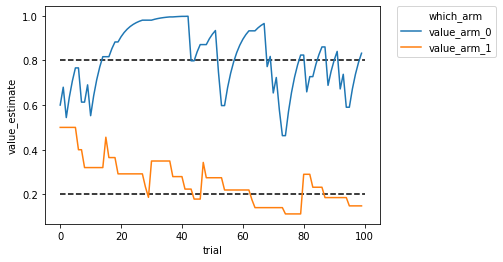

In [8]:
# Plot outcomes
plot_2arm_bandit = sns.lineplot(
    x = 'trial',
    y = 'value_estimate',
    hue = 'which_arm',
    data=pd.melt(
        frame = exp_2arm_bandit,
        id_vars = ['trial', 'choice', 'reward'],
        var_name = 'which_arm',
        value_name = 'value_estimate'
        )
)
plot_2arm_bandit.hlines(
    y = p_rewards,
    xmin = 0,
    xmax = n_trials,
    linestyles = 'dashed'
    )

plot_2arm_bandit.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## 2.3 Ten-armed bandit results

And when we perform an experiment with the ten-armed bandit, we (qualitatively) see the exact pattern we'd expect. In the plot, the blues are ordered from darkest to lightest, reflecting that our learning agent managed to (more-or-less) learn accurately. We also see evidence that the agent explored "suboptimal" stimuli instead of simply exploiting the stimulus with the highest value estimate.

In [9]:
# Initialize experiment
n_trials = 1000
p_rewards = np.linspace(start = 0, stop = 1, num = 10)
agent_alpha = 0.2
agent_beta = 3

exp_10arm_bandit = sim_n_arm_bandit(n_trials, p_rewards, 0.5, agent_alpha, agent_beta)

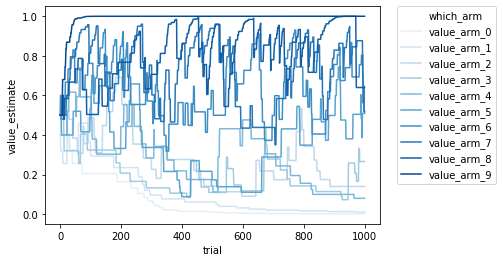

In [10]:
# Plot outcomes
plot_10arm_bandit = sns.lineplot(
    x = 'trial',
    y = 'value_estimate',
    hue = 'which_arm',
    palette = 'Blues',
    data=pd.melt(
        frame = exp_10arm_bandit,
        id_vars = ['trial', 'choice', 'reward'],
        var_name = 'which_arm',
        value_name = 'value_estimate'
        )
)

plot_10arm_bandit.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)